In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_london_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_london_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_london_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [ ]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [ ]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id',
    "nearby_restaurants_bars", "nearby_transport", "mean_price_neighbors",
    "nearby_airbnbs_count",
    "neighbourhood_Barking and Dagenham", "neighbourhood_Barnet", "neighbourhood_Bexley",
    "neighbourhood_Brent", "neighbourhood_Bromley", "neighbourhood_Camden",
    "neighbourhood_City of London", "neighbourhood_Croydon", "neighbourhood_Ealing",
    "neighbourhood_Enfield", "neighbourhood_Greenwich", "neighbourhood_Hackney",
    "neighbourhood_Hammersmith and Fulham", "neighbourhood_Haringey", "neighbourhood_Harrow",
    "neighbourhood_Havering", "neighbourhood_Hillingdon", "neighbourhood_Hounslow",
    "neighbourhood_Islington", "neighbourhood_Kensington and Chelsea",
    "neighbourhood_Kingston upon Thames", "neighbourhood_Lambeth", "neighbourhood_Lewisham",
    "neighbourhood_Merton", "neighbourhood_Newham", "neighbourhood_Redbridge",
    "neighbourhood_Richmond upon Thames", "neighbourhood_Southwark", "neighbourhood_Sutton",
    "neighbourhood_Tower Hamlets", "neighbourhood_Waltham Forest", "neighbourhood_Wandsworth",
    "neighbourhood_Westminster", "season_Autumn", "is_holiday", "is_school_holiday"])


    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


<ipython-input-10-9ca89abc452e>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-10-9ca89abc452e>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-10-9ca89abc452e>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 11:59:15,851] A new study created in memory with name: no-name-e8e4cb37-5885-4fb0-a893-bb1df7b734fe
Training PEGNN: 100%|██████████| 50/50 [00:28<00:00,  1.72it/s]
[I 2024-08-13 11:59:45,583] Trial 0 finished with value: 1.280341625213623 and parameters: {'hidden_channels': 75, 'lr': 0.00010788109542534936, 'k': 29, 'dropout_rate': 0.24100830787747568}. Best is trial 0 with value: 1.280341625213623.
Training PEGNN: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]
[I 2024-08-13 12:00:26,144] Trial 1 finished with value: 0.874817430973053 and parameters: {'hidden_channels': 101, 'lr': 0.0005436521902061048, 'k': 37, 'dropout_rate': 0.29859962617619895}. Best is trial 1 with value: 0.874817430973053.
Training PEGNN: 100%|██████████| 50/50 [01:29<00:00,  1.79s/it]
[I 2024-08-13 12:01:57,581] Trial 2 finished with value: 0.8866778016090393 and parameters: {'hidden_channels': 40, 'lr': 0.001000614647324289, 'k': 102, 'dropout_rate': 0.40240303836010227}. Best is trial 1 with val

Best parameters:  {'hidden_channels': 113, 'lr': 0.005275206323615922, 'k': 45, 'dropout_rate': 0.17214034280013257}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.7237058877944946, Training R-squared: -0.12073917346159635, Training MAE: 0.7275733947753906, Training MSE: 1.7237060070037842
Epoch 1, Validation Loss: 1.4345545768737793, Validation R-squared: 0.016325466834016145, Validation MAE: 0.898556649684906, Validation MSE: 1.4345544576644897


Final training:   0%|          | 2/500 [00:02<11:14,  1.36s/it]

Epoch 2, Training Loss: 1.4995152950286865, Training R-squared: 0.02502778501004277, Training MAE: 0.9404615163803101, Training MSE: 1.4995152950286865
Epoch 2, Validation Loss: 1.2305715084075928, Validation R-squared: 0.15619659825135734, Validation MAE: 0.7018837928771973, Validation MSE: 1.2305715084075928


Final training:   1%|          | 3/500 [00:03<10:36,  1.28s/it]

Epoch 3, Training Loss: 1.252406358718872, Training R-squared: 0.18569591505077243, Training MAE: 0.7333986163139343, Training MSE: 1.252406358718872
Epoch 3, Validation Loss: 1.197220802307129, Validation R-squared: 0.1790652126966329, Validation MAE: 0.6390070915222168, Validation MSE: 1.1972209215164185


Final training:   1%|          | 4/500 [00:05<10:21,  1.25s/it]

Epoch 4, Training Loss: 1.203931212425232, Training R-squared: 0.21721400066924146, Training MAE: 0.6645132899284363, Training MSE: 1.203931450843811
Epoch 4, Validation Loss: 1.1390433311462402, Validation R-squared: 0.21895752558915904, Validation MAE: 0.6104580163955688, Validation MSE: 1.1390433311462402


Final training:   1%|          | 5/500 [00:06<10:38,  1.29s/it]

Epoch 5, Training Loss: 1.13577401638031, Training R-squared: 0.26152926866807935, Training MAE: 0.6350199580192566, Training MSE: 1.13577401638031
Epoch 5, Validation Loss: 1.0702718496322632, Validation R-squared: 0.2661142284711068, Validation MAE: 0.6039483547210693, Validation MSE: 1.0702717304229736


Final training:   1%|          | 6/500 [00:07<10:36,  1.29s/it]

Epoch 6, Training Loss: 1.0839405059814453, Training R-squared: 0.29523101055560796, Training MAE: 0.6346113681793213, Training MSE: 1.0839403867721558
Epoch 6, Validation Loss: 1.03252375125885, Validation R-squared: 0.29199808980345965, Validation MAE: 0.6055483222007751, Validation MSE: 1.03252375125885


Final training:   1%|▏         | 7/500 [00:08<10:18,  1.26s/it]

Epoch 7, Training Loss: 1.0671545267105103, Training R-squared: 0.3061451319695607, Training MAE: 0.6448253393173218, Training MSE: 1.0671544075012207
Epoch 7, Validation Loss: 0.9928150773048401, Validation R-squared: 0.31922635935585186, Validation MAE: 0.5624463558197021, Validation MSE: 0.9928151369094849


Final training:   2%|▏         | 8/500 [00:10<10:05,  1.23s/it]

Epoch 8, Training Loss: 1.0011152029037476, Training R-squared: 0.34908328474821304, Training MAE: 0.5949622392654419, Training MSE: 1.0011152029037476
Epoch 8, Validation Loss: 0.9898164868354797, Validation R-squared: 0.32128249947928267, Validation MAE: 0.5169273614883423, Validation MSE: 0.989816427230835


Final training:   2%|▏         | 9/500 [00:11<09:56,  1.21s/it]

Epoch 9, Training Loss: 0.9766683578491211, Training R-squared: 0.36497846676704415, Training MAE: 0.5373186469078064, Training MSE: 0.9766682982444763
Epoch 9, Validation Loss: 0.9695132970809937, Validation R-squared: 0.33520434268152244, Validation MAE: 0.49938225746154785, Validation MSE: 0.9695133566856384


Final training:   2%|▏         | 10/500 [00:12<09:54,  1.21s/it]

Epoch 10, Training Loss: 0.9503827095031738, Training R-squared: 0.38206915981132206, Training MAE: 0.5174964070320129, Training MSE: 0.950382649898529
Epoch 10, Validation Loss: 0.9302238821983337, Validation R-squared: 0.3621450869489583, Validation MAE: 0.5170602798461914, Validation MSE: 0.9302240014076233


Final training:   2%|▏         | 11/500 [00:13<09:51,  1.21s/it]

Epoch 11, Training Loss: 0.919202446937561, Training R-squared: 0.4023422790939204, Training MAE: 0.5393784046173096, Training MSE: 0.919202446937561
Epoch 11, Validation Loss: 0.9234567880630493, Validation R-squared: 0.3667853459622237, Validation MAE: 0.525989294052124, Validation MSE: 0.9234567284584045


Final training:   2%|▏         | 12/500 [00:14<09:51,  1.21s/it]

Epoch 12, Training Loss: 0.915040135383606, Training R-squared: 0.40504859998931586, Training MAE: 0.5530143976211548, Training MSE: 0.915040135383606
Epoch 12, Validation Loss: 0.9176908731460571, Validation R-squared: 0.370739061508948, Validation MAE: 0.4867917001247406, Validation MSE: 0.9176908731460571


Final training:   3%|▎         | 13/500 [00:16<09:45,  1.20s/it]

Epoch 13, Training Loss: 0.897219717502594, Training R-squared: 0.4166353098506532, Training MAE: 0.507091760635376, Training MSE: 0.8972196578979492
Epoch 13, Validation Loss: 0.92706698179245, Validation R-squared: 0.36430988355355043, Validation MAE: 0.4763167202472687, Validation MSE: 0.9270669221878052


Final training:   3%|▎         | 14/500 [00:17<09:47,  1.21s/it]

Epoch 14, Training Loss: 0.8839331269264221, Training R-squared: 0.42527411333752885, Training MAE: 0.4882633090019226, Training MSE: 0.8839331269264221
Epoch 14, Validation Loss: 0.8994751572608948, Validation R-squared: 0.38322958003528884, Validation MAE: 0.477298766374588, Validation MSE: 0.8994751572608948


Final training:   3%|▎         | 15/500 [00:18<10:07,  1.25s/it]

Epoch 15, Training Loss: 0.8621512055397034, Training R-squared: 0.4394364948666367, Training MAE: 0.49688851833343506, Training MSE: 0.8621512651443481
Epoch 15, Validation Loss: 0.8859383463859558, Validation R-squared: 0.3925117930654273, Validation MAE: 0.4917171597480774, Validation MSE: 0.8859382271766663


Final training:   3%|▎         | 16/500 [00:20<10:12,  1.27s/it]

Epoch 16, Training Loss: 0.8656036853790283, Training R-squared: 0.4371917758774271, Training MAE: 0.5186920762062073, Training MSE: 0.8656036853790283
Epoch 16, Validation Loss: 0.879306972026825, Validation R-squared: 0.39705887602434475, Validation MAE: 0.482072114944458, Validation MSE: 0.8793070316314697


Final training:   3%|▎         | 17/500 [00:21<10:03,  1.25s/it]

Epoch 17, Training Loss: 0.8440741300582886, Training R-squared: 0.451190060874445, Training MAE: 0.49848413467407227, Training MSE: 0.8440741896629333
Epoch 17, Validation Loss: 0.8885781168937683, Validation R-squared: 0.39070164845477406, Validation MAE: 0.4738200008869171, Validation MSE: 0.8885781764984131


Final training:   4%|▎         | 18/500 [00:22<09:52,  1.23s/it]

Epoch 18, Training Loss: 0.8360992074012756, Training R-squared: 0.456375335889861, Training MAE: 0.48124492168426514, Training MSE: 0.8360992074012756
Epoch 18, Validation Loss: 0.8841785192489624, Validation R-squared: 0.3937184903178661, Validation MAE: 0.4771272540092468, Validation MSE: 0.8841785192489624


Final training:   4%|▍         | 19/500 [00:23<09:47,  1.22s/it]

Epoch 19, Training Loss: 0.8361178636550903, Training R-squared: 0.45636320468094604, Training MAE: 0.48471784591674805, Training MSE: 0.8361178636550903
Epoch 19, Validation Loss: 0.8685159087181091, Validation R-squared: 0.4044582971942262, Validation MAE: 0.4882495105266571, Validation MSE: 0.8685159683227539


Final training:   4%|▍         | 20/500 [00:24<09:43,  1.21s/it]

Epoch 20, Training Loss: 0.8185890913009644, Training R-squared: 0.4677602520366878, Training MAE: 0.4970564842224121, Training MSE: 0.8185890913009644
Epoch 20, Validation Loss: 0.86178058385849, Validation R-squared: 0.40907671777276566, Validation MAE: 0.5027444958686829, Validation MSE: 0.8617806434631348


Final training:   4%|▍         | 21/500 [00:26<09:40,  1.21s/it]

Epoch 21, Training Loss: 0.8253410458564758, Training R-squared: 0.463370125314831, Training MAE: 0.5198705792427063, Training MSE: 0.8253411650657654
Epoch 21, Validation Loss: 0.8573530912399292, Validation R-squared: 0.41211267364687776, Validation MAE: 0.49914923310279846, Validation MSE: 0.857353150844574


Final training:   4%|▍         | 22/500 [00:27<09:37,  1.21s/it]

Epoch 22, Training Loss: 0.8239644169807434, Training R-squared: 0.46426526125001877, Training MAE: 0.5135812759399414, Training MSE: 0.8239644169807434
Epoch 22, Validation Loss: 0.857726514339447, Validation R-squared: 0.4118565928039527, Validation MAE: 0.4839669167995453, Validation MSE: 0.8577265739440918


Final training:   5%|▍         | 23/500 [00:28<09:32,  1.20s/it]

Epoch 23, Training Loss: 0.8136581778526306, Training R-squared: 0.4709662393893359, Training MAE: 0.4905804991722107, Training MSE: 0.8136582970619202
Epoch 23, Validation Loss: 0.858788251876831, Validation R-squared: 0.4111285418406744, Validation MAE: 0.47651830315589905, Validation MSE: 0.8587883114814758


Final training:   5%|▍         | 24/500 [00:29<09:37,  1.21s/it]

Epoch 24, Training Loss: 0.8050748109817505, Training R-squared: 0.4765470915755007, Training MAE: 0.4787784814834595, Training MSE: 0.8050748705863953
Epoch 24, Validation Loss: 0.849812388420105, Validation R-squared: 0.4172833819038543, Validation MAE: 0.47594591975212097, Validation MSE: 0.8498123288154602


Final training:   5%|▌         | 25/500 [00:30<09:52,  1.25s/it]

Epoch 25, Training Loss: 0.7885399460792542, Training R-squared: 0.4872980011613177, Training MAE: 0.47707849740982056, Training MSE: 0.7885398864746094
Epoch 25, Validation Loss: 0.8418239951133728, Validation R-squared: 0.4227610296936952, Validation MAE: 0.4807691276073456, Validation MSE: 0.841823935508728


Final training:   5%|▌         | 26/500 [00:32<09:51,  1.25s/it]

Epoch 26, Training Loss: 0.7917011976242065, Training R-squared: 0.48524255205210143, Training MAE: 0.4862735867500305, Training MSE: 0.7917011976242065
Epoch 26, Validation Loss: 0.8383200764656067, Validation R-squared: 0.42516365417239543, Validation MAE: 0.4780239760875702, Validation MSE: 0.8383200764656067


Final training:   5%|▌         | 27/500 [00:33<09:45,  1.24s/it]

Epoch 27, Training Loss: 0.7888849973678589, Training R-squared: 0.4870736253243273, Training MAE: 0.48228394985198975, Training MSE: 0.7888849973678589
Epoch 27, Validation Loss: 0.8377293944358826, Validation R-squared: 0.4255686623017271, Validation MAE: 0.46454253792762756, Validation MSE: 0.8377293944358826


Final training:   6%|▌         | 28/500 [00:34<09:38,  1.22s/it]

Epoch 28, Training Loss: 0.7848643660545349, Training R-squared: 0.48968779984611954, Training MAE: 0.46766120195388794, Training MSE: 0.7848643660545349
Epoch 28, Validation Loss: 0.8429043292999268, Validation R-squared: 0.42202016577038426, Validation MAE: 0.4550507366657257, Validation MSE: 0.8429044485092163


Final training:   6%|▌         | 29/500 [00:35<09:29,  1.21s/it]

Epoch 29, Training Loss: 0.7706478834152222, Training R-squared: 0.498931238910054, Training MAE: 0.44953614473342896, Training MSE: 0.7706478834152222
Epoch 29, Validation Loss: 0.833453357219696, Validation R-squared: 0.4285007386034998, Validation MAE: 0.45475098490715027, Validation MSE: 0.833453357219696


Final training:   6%|▌         | 30/500 [00:36<09:23,  1.20s/it]

Epoch 30, Training Loss: 0.7714685201644897, Training R-squared: 0.4983976997941788, Training MAE: 0.4539799094200134, Training MSE: 0.7714684009552002
Epoch 30, Validation Loss: 0.821498453617096, Validation R-squared: 0.436698189258398, Validation MAE: 0.46434497833251953, Validation MSE: 0.8214985132217407


Final training:   6%|▌         | 31/500 [00:38<09:23,  1.20s/it]

Epoch 31, Training Loss: 0.7710601687431335, Training R-squared: 0.49866314155863023, Training MAE: 0.46737873554229736, Training MSE: 0.7710602283477783
Epoch 31, Validation Loss: 0.8166482448577881, Validation R-squared: 0.44002395724351406, Validation MAE: 0.46603521704673767, Validation MSE: 0.8166483044624329


Final training:   6%|▋         | 32/500 [00:39<09:22,  1.20s/it]

Epoch 32, Training Loss: 0.7647475600242615, Training R-squared: 0.5027675789529189, Training MAE: 0.4703270196914673, Training MSE: 0.7647475600242615
Epoch 32, Validation Loss: 0.8152977228164673, Validation R-squared: 0.440950085133069, Validation MAE: 0.45255711674690247, Validation MSE: 0.8152977228164673


Final training:   7%|▋         | 33/500 [00:40<09:23,  1.21s/it]

Epoch 33, Training Loss: 0.7544426321983337, Training R-squared: 0.5094677267586036, Training MAE: 0.45287972688674927, Training MSE: 0.7544426918029785
Epoch 33, Validation Loss: 0.8199248909950256, Validation R-squared: 0.43777715948787455, Validation MAE: 0.44685816764831543, Validation MSE: 0.8199250102043152


Final training:   7%|▋         | 34/500 [00:41<09:22,  1.21s/it]

Epoch 34, Training Loss: 0.7486670613288879, Training R-squared: 0.5132229634999648, Training MAE: 0.4440350830554962, Training MSE: 0.7486670613288879
Epoch 34, Validation Loss: 0.8083379864692688, Validation R-squared: 0.4457223542958725, Validation MAE: 0.4511149227619171, Validation MSE: 0.8083379864692688


Final training:   7%|▋         | 35/500 [00:43<09:32,  1.23s/it]

Epoch 35, Training Loss: 0.7362843155860901, Training R-squared: 0.521274088037659, Training MAE: 0.4489184617996216, Training MSE: 0.7362843155860901
Epoch 35, Validation Loss: 0.7998825907707214, Validation R-squared: 0.451520222354894, Validation MAE: 0.4661652147769928, Validation MSE: 0.7998825907707214


Final training:   7%|▋         | 36/500 [00:44<09:50,  1.27s/it]

Epoch 36, Training Loss: 0.7455822229385376, Training R-squared: 0.5152287752614158, Training MAE: 0.47261205315589905, Training MSE: 0.7455822229385376
Epoch 36, Validation Loss: 0.7966687679290771, Validation R-squared: 0.45372391366715636, Validation MAE: 0.46223223209381104, Validation MSE: 0.7966688275337219


Final training:   7%|▋         | 37/500 [00:45<09:44,  1.26s/it]

Epoch 37, Training Loss: 0.7251223921775818, Training R-squared: 0.528531550663836, Training MAE: 0.4631976783275604, Training MSE: 0.7251223921775818
Epoch 37, Validation Loss: 0.7986338138580322, Validation R-squared: 0.45237652519431615, Validation MAE: 0.4487100839614868, Validation MSE: 0.7986338138580322


Final training:   8%|▊         | 38/500 [00:46<09:35,  1.24s/it]

Epoch 38, Training Loss: 0.7319399118423462, Training R-squared: 0.5240987886668256, Training MAE: 0.44858720898628235, Training MSE: 0.7319399118423462
Epoch 38, Validation Loss: 0.7989212870597839, Validation R-squared: 0.45217948539128217, Validation MAE: 0.44369813799858093, Validation MSE: 0.7989212274551392


Final training:   8%|▊         | 39/500 [00:48<09:34,  1.25s/it]

Epoch 39, Training Loss: 0.718927264213562, Training R-squared: 0.5325595440935064, Training MAE: 0.439136803150177, Training MSE: 0.718927264213562
Epoch 39, Validation Loss: 0.7886852025985718, Validation R-squared: 0.4591983191383622, Validation MAE: 0.45108655095100403, Validation MSE: 0.7886852025985718


Final training:   8%|▊         | 40/500 [00:49<09:32,  1.24s/it]

Epoch 40, Training Loss: 0.7261018753051758, Training R-squared: 0.5278947195408215, Training MAE: 0.4486900269985199, Training MSE: 0.726101815700531
Epoch 40, Validation Loss: 0.7862135171890259, Validation R-squared: 0.4608931299559602, Validation MAE: 0.45757490396499634, Validation MSE: 0.7862135171890259


Final training:   8%|▊         | 41/500 [00:50<09:26,  1.23s/it]

Epoch 41, Training Loss: 0.7107666730880737, Training R-squared: 0.53786549565724, Training MAE: 0.455567866563797, Training MSE: 0.7107666730880737
Epoch 41, Validation Loss: 0.7863950133323669, Validation R-squared: 0.46076865973728054, Validation MAE: 0.44321686029434204, Validation MSE: 0.7863950133323669


Final training:   8%|▊         | 42/500 [00:51<09:21,  1.23s/it]

Epoch 42, Training Loss: 0.714506208896637, Training R-squared: 0.535434106874821, Training MAE: 0.4363381862640381, Training MSE: 0.714506208896637
Epoch 42, Validation Loss: 0.7867724895477295, Validation R-squared: 0.4605098412972566, Validation MAE: 0.4389687478542328, Validation MSE: 0.7867724895477295


Final training:   9%|▊         | 43/500 [00:53<09:19,  1.22s/it]

Epoch 43, Training Loss: 0.7115088701248169, Training R-squared: 0.5373829087423101, Training MAE: 0.4339708685874939, Training MSE: 0.7115088701248169
Epoch 43, Validation Loss: 0.7782977223396301, Validation R-squared: 0.4663209836298977, Validation MAE: 0.4453395903110504, Validation MSE: 0.7782977223396301


Final training:   9%|▉         | 44/500 [00:54<09:15,  1.22s/it]

Epoch 44, Training Loss: 0.7028627395629883, Training R-squared: 0.5430046112105467, Training MAE: 0.44301721453666687, Training MSE: 0.7028626203536987
Epoch 44, Validation Loss: 0.7737206816673279, Validation R-squared: 0.4694594714442012, Validation MAE: 0.4489559531211853, Validation MSE: 0.7737206220626831


Final training:   9%|▉         | 45/500 [00:55<09:21,  1.23s/it]

Epoch 45, Training Loss: 0.6874848008155823, Training R-squared: 0.5530031586649831, Training MAE: 0.44132569432258606, Training MSE: 0.687484860420227
Epoch 45, Validation Loss: 0.7712185382843018, Validation R-squared: 0.47117510776324956, Validation MAE: 0.44568291306495667, Validation MSE: 0.7712186574935913


Final training:   9%|▉         | 46/500 [00:56<09:36,  1.27s/it]

Epoch 46, Training Loss: 0.6911957859992981, Training R-squared: 0.550590320255069, Training MAE: 0.4398638904094696, Training MSE: 0.6911957859992981
Epoch 46, Validation Loss: 0.7731749415397644, Validation R-squared: 0.46983366257537196, Validation MAE: 0.43855851888656616, Validation MSE: 0.7731749415397644


Final training:   9%|▉         | 47/500 [00:58<09:28,  1.26s/it]

Epoch 47, Training Loss: 0.6780457496643066, Training R-squared: 0.5591403690873111, Training MAE: 0.42843952775001526, Training MSE: 0.6780457496643066
Epoch 47, Validation Loss: 0.7661742568016052, Validation R-squared: 0.4746340540612811, Validation MAE: 0.44247034192085266, Validation MSE: 0.7661742568016052


Final training:  10%|▉         | 48/500 [00:59<09:20,  1.24s/it]

Epoch 48, Training Loss: 0.6910052299499512, Training R-squared: 0.5507142172798029, Training MAE: 0.438283771276474, Training MSE: 0.6910052299499512
Epoch 48, Validation Loss: 0.7628612518310547, Validation R-squared: 0.47690579418215595, Validation MAE: 0.44493263959884644, Validation MSE: 0.7628612518310547


Final training:  10%|▉         | 49/500 [01:00<09:09,  1.22s/it]

Epoch 49, Training Loss: 0.6760324239730835, Training R-squared: 0.5604494117981733, Training MAE: 0.4366556704044342, Training MSE: 0.6760324239730835
Epoch 49, Validation Loss: 0.7647139430046082, Validation R-squared: 0.47563537777535003, Validation MAE: 0.43815377354621887, Validation MSE: 0.7647139430046082


Final training:  10%|█         | 50/500 [01:01<09:09,  1.22s/it]

Epoch 50, Training Loss: 0.6767600774765015, Training R-squared: 0.559976290977305, Training MAE: 0.4291180968284607, Training MSE: 0.6767600774765015
Epoch 50, Validation Loss: 0.7609731554985046, Validation R-squared: 0.4782003987675527, Validation MAE: 0.4404057562351227, Validation MSE: 0.7609732151031494


Final training:  10%|█         | 51/500 [01:02<09:03,  1.21s/it]

Epoch 51, Training Loss: 0.6647385954856873, Training R-squared: 0.5677925665893543, Training MAE: 0.4332091510295868, Training MSE: 0.6647385954856873
Epoch 51, Validation Loss: 0.7573165893554688, Validation R-squared: 0.48070775317888426, Validation MAE: 0.4445023834705353, Validation MSE: 0.7573165893554688


Final training:  10%|█         | 52/500 [01:04<09:00,  1.21s/it]

Epoch 52, Training Loss: 0.6676267981529236, Training R-squared: 0.5659146821240524, Training MAE: 0.4377468228340149, Training MSE: 0.6676267981529236
Epoch 52, Validation Loss: 0.7600283026695251, Validation R-squared: 0.4788483074825354, Validation MAE: 0.4343341588973999, Validation MSE: 0.7600283026695251


Final training:  11%|█         | 53/500 [01:05<09:00,  1.21s/it]

Epoch 53, Training Loss: 0.6660273671150208, Training R-squared: 0.5669546176869507, Training MAE: 0.42374512553215027, Training MSE: 0.6660273671150208
Epoch 53, Validation Loss: 0.7559488415718079, Validation R-squared: 0.4816456520145336, Validation MAE: 0.4350791871547699, Validation MSE: 0.7559488415718079


Final training:  11%|█         | 54/500 [01:06<08:57,  1.20s/it]

Epoch 54, Training Loss: 0.6633439660072327, Training R-squared: 0.5686993583921388, Training MAE: 0.4265613555908203, Training MSE: 0.6633439064025879
Epoch 54, Validation Loss: 0.7517128586769104, Validation R-squared: 0.4845502318696193, Validation MAE: 0.439004510641098, Validation MSE: 0.7517129182815552


Final training:  11%|█         | 55/500 [01:07<09:02,  1.22s/it]

Epoch 55, Training Loss: 0.663682758808136, Training R-squared: 0.5684790491763281, Training MAE: 0.4316166639328003, Training MSE: 0.663682758808136
Epoch 55, Validation Loss: 0.7519612312316895, Validation R-squared: 0.48437992115196704, Validation MAE: 0.4357551336288452, Validation MSE: 0.7519612312316895


Final training:  11%|█         | 56/500 [01:09<09:11,  1.24s/it]

Epoch 56, Training Loss: 0.6512617468833923, Training R-squared: 0.5765551435050198, Training MAE: 0.4243779182434082, Training MSE: 0.6512616276741028
Epoch 56, Validation Loss: 0.7500994205474854, Validation R-squared: 0.4856565295549544, Validation MAE: 0.4370078146457672, Validation MSE: 0.7500994801521301


Final training:  11%|█▏        | 57/500 [01:10<09:15,  1.25s/it]

Epoch 57, Training Loss: 0.6464062333106995, Training R-squared: 0.5797121038524833, Training MAE: 0.4257635772228241, Training MSE: 0.6464062333106995
Epoch 57, Validation Loss: 0.7513876557350159, Validation R-squared: 0.4847732047120261, Validation MAE: 0.43373438715934753, Validation MSE: 0.7513877153396606


Final training:  12%|█▏        | 58/500 [01:11<09:07,  1.24s/it]

Epoch 58, Training Loss: 0.6348883509635925, Training R-squared: 0.5872009532708864, Training MAE: 0.42141658067703247, Training MSE: 0.6348883509635925
Epoch 58, Validation Loss: 0.7512750029563904, Validation R-squared: 0.4848504309077345, Validation MAE: 0.43293172121047974, Validation MSE: 0.7512750029563904


Final training:  12%|█▏        | 59/500 [01:12<09:00,  1.23s/it]

Epoch 59, Training Loss: 0.6422417163848877, Training R-squared: 0.582419862790414, Training MAE: 0.4189912974834442, Training MSE: 0.6422416567802429
Epoch 59, Validation Loss: 0.7464514970779419, Validation R-squared: 0.48815795869740475, Validation MAE: 0.4372681677341461, Validation MSE: 0.7464514970779419


Final training:  12%|█▏        | 60/500 [01:13<08:56,  1.22s/it]

Epoch 60, Training Loss: 0.6360263824462891, Training R-squared: 0.5864609992850585, Training MAE: 0.42582967877388, Training MSE: 0.6360263824462891
Epoch 60, Validation Loss: 0.7457196116447449, Validation R-squared: 0.48865980033995315, Validation MAE: 0.4337797164916992, Validation MSE: 0.7457196116447449


Final training:  12%|█▏        | 61/500 [01:15<08:49,  1.21s/it]

Epoch 61, Training Loss: 0.6258925199508667, Training R-squared: 0.5930499489808552, Training MAE: 0.4180770814418793, Training MSE: 0.6258925199508667
Epoch 61, Validation Loss: 0.7442848086357117, Validation R-squared: 0.48964366748850974, Validation MAE: 0.43392205238342285, Validation MSE: 0.7442848086357117


Final training:  12%|█▏        | 62/500 [01:16<08:50,  1.21s/it]

Epoch 62, Training Loss: 0.6306580305099487, Training R-squared: 0.5899514717105094, Training MAE: 0.4225197732448578, Training MSE: 0.630657970905304
Epoch 62, Validation Loss: 0.7419464588165283, Validation R-squared: 0.49124703749944887, Validation MAE: 0.4352891743183136, Validation MSE: 0.7419465184211731


Final training:  13%|█▎        | 63/500 [01:17<08:48,  1.21s/it]

Epoch 63, Training Loss: 0.6116498708724976, Training R-squared: 0.6023103834237924, Training MAE: 0.4192476272583008, Training MSE: 0.6116499304771423
Epoch 63, Validation Loss: 0.7452885508537292, Validation R-squared: 0.4889553945719134, Validation MAE: 0.43139275908470154, Validation MSE: 0.7452885508537292


Final training:  13%|█▎        | 64/500 [01:18<08:46,  1.21s/it]

Epoch 64, Training Loss: 0.6255000233650208, Training R-squared: 0.5933051384642448, Training MAE: 0.4147911071777344, Training MSE: 0.6255000233650208
Epoch 64, Validation Loss: 0.7387528419494629, Validation R-squared: 0.4934369276745165, Validation MAE: 0.43881016969680786, Validation MSE: 0.7387527823448181


Final training:  13%|█▎        | 65/500 [01:19<08:49,  1.22s/it]

Epoch 65, Training Loss: 0.6150960922241211, Training R-squared: 0.6000697441184724, Training MAE: 0.4241074323654175, Training MSE: 0.6150960326194763
Epoch 65, Validation Loss: 0.7414148449897766, Validation R-squared: 0.49161158411319095, Validation MAE: 0.4291914701461792, Validation MSE: 0.7414147853851318


Final training:  13%|█▎        | 66/500 [01:21<09:08,  1.26s/it]

Epoch 66, Training Loss: 0.6138588190078735, Training R-squared: 0.6008741664870788, Training MAE: 0.4112665057182312, Training MSE: 0.6138588190078735
Epoch 66, Validation Loss: 0.73822420835495, Validation R-squared: 0.4937993931658231, Validation MAE: 0.4304058849811554, Validation MSE: 0.7382242679595947


Final training:  13%|█▎        | 67/500 [01:22<09:16,  1.29s/it]

Epoch 67, Training Loss: 0.6011034846305847, Training R-squared: 0.6091675759449822, Training MAE: 0.4095720946788788, Training MSE: 0.6011034846305847
Epoch 67, Validation Loss: 0.7343400120735168, Validation R-squared: 0.496462794163237, Validation MAE: 0.443581223487854, Validation MSE: 0.7343400120735168


Final training:  14%|█▎        | 68/500 [01:23<09:04,  1.26s/it]

Epoch 68, Training Loss: 0.6088210344314575, Training R-squared: 0.6041497133694589, Training MAE: 0.43100273609161377, Training MSE: 0.6088209748268127
Epoch 68, Validation Loss: 0.7664249539375305, Validation R-squared: 0.4744621361773591, Validation MAE: 0.42633798718452454, Validation MSE: 0.7664250135421753


Final training:  14%|█▍        | 69/500 [01:25<08:56,  1.24s/it]

Epoch 69, Training Loss: 0.6150255799293518, Training R-squared: 0.6001155501239417, Training MAE: 0.40056827664375305, Training MSE: 0.6150255799293518
Epoch 69, Validation Loss: 0.7335132956504822, Validation R-squared: 0.4970296358308064, Validation MAE: 0.43843892216682434, Validation MSE: 0.733513355255127


Final training:  14%|█▍        | 70/500 [01:26<08:54,  1.24s/it]

Epoch 70, Training Loss: 0.5948949456214905, Training R-squared: 0.613204342636079, Training MAE: 0.41952311992645264, Training MSE: 0.5948948860168457
Epoch 70, Validation Loss: 0.7355658411979675, Validation R-squared: 0.4956222293241177, Validation MAE: 0.4514039158821106, Validation MSE: 0.7355658411979675


Final training:  14%|█▍        | 71/500 [01:27<08:49,  1.23s/it]

Epoch 71, Training Loss: 0.6101699471473694, Training R-squared: 0.6032726089797431, Training MAE: 0.4361423850059509, Training MSE: 0.6101700067520142
Epoch 71, Validation Loss: 0.7577648758888245, Validation R-squared: 0.4804003084625691, Validation MAE: 0.42707058787345886, Validation MSE: 0.7577648758888245


Final training:  14%|█▍        | 72/500 [01:28<08:45,  1.23s/it]

Epoch 72, Training Loss: 0.5915029048919678, Training R-squared: 0.6154097852818342, Training MAE: 0.3998883366584778, Training MSE: 0.5915029048919678
Epoch 72, Validation Loss: 0.7371762990951538, Validation R-squared: 0.4945179868169711, Validation MAE: 0.43105047941207886, Validation MSE: 0.7371762990951538


Final training:  15%|█▍        | 73/500 [01:29<08:44,  1.23s/it]

Epoch 73, Training Loss: 0.5766955018043518, Training R-squared: 0.6250374469859309, Training MAE: 0.40131282806396484, Training MSE: 0.5766955018043518
Epoch 73, Validation Loss: 0.7378057241439819, Validation R-squared: 0.4940863509971227, Validation MAE: 0.45361992716789246, Validation MSE: 0.7378057837486267


Final training:  15%|█▍        | 74/500 [01:31<08:43,  1.23s/it]

Epoch 74, Training Loss: 0.5922526717185974, Training R-squared: 0.6149223118894211, Training MAE: 0.4316162168979645, Training MSE: 0.5922526717185974
Epoch 74, Validation Loss: 0.7474304437637329, Validation R-squared: 0.4874867164398127, Validation MAE: 0.4275144040584564, Validation MSE: 0.7474304437637329


Final training:  15%|█▌        | 75/500 [01:32<08:44,  1.23s/it]

Epoch 75, Training Loss: 0.578843891620636, Training R-squared: 0.6236405444304376, Training MAE: 0.39706072211265564, Training MSE: 0.5788439512252808
Epoch 75, Validation Loss: 0.7440052628517151, Validation R-squared: 0.48983531088219834, Validation MAE: 0.4281406104564667, Validation MSE: 0.7440053224563599


Final training:  15%|█▌        | 76/500 [01:33<09:00,  1.27s/it]

Epoch 76, Training Loss: 0.5642257332801819, Training R-squared: 0.6331451501188616, Training MAE: 0.3945409655570984, Training MSE: 0.5642257928848267
Epoch 76, Validation Loss: 0.7398561835289001, Validation R-squared: 0.4926803640249282, Validation MAE: 0.4546163082122803, Validation MSE: 0.7398561239242554


Final training:  15%|█▌        | 77/500 [01:35<09:00,  1.28s/it]

Epoch 77, Training Loss: 0.5724793672561646, Training R-squared: 0.6277787185839161, Training MAE: 0.4296022057533264, Training MSE: 0.5724793672561646
Epoch 77, Validation Loss: 0.7375078797340393, Validation R-squared: 0.49429061436075905, Validation MAE: 0.43233558535575867, Validation MSE: 0.7375078201293945


Final training:  16%|█▌        | 78/500 [01:36<08:50,  1.26s/it]

Epoch 78, Training Loss: 0.5491847991943359, Training R-squared: 0.642924678309704, Training MAE: 0.3993096649646759, Training MSE: 0.5491847991943359
Epoch 78, Validation Loss: 0.7543943524360657, Validation R-squared: 0.48271150953903663, Validation MAE: 0.4290063977241516, Validation MSE: 0.7543943524360657


Final training:  16%|█▌        | 79/500 [01:37<08:43,  1.24s/it]

Epoch 79, Training Loss: 0.5644282102584839, Training R-squared: 0.633013538090031, Training MAE: 0.3930538594722748, Training MSE: 0.5644281506538391
Epoch 79, Validation Loss: 0.7368966341018677, Validation R-squared: 0.4947097759367215, Validation MAE: 0.44848787784576416, Validation MSE: 0.7368965744972229


Final training:  16%|█▌        | 80/500 [01:38<08:35,  1.23s/it]

Epoch 80, Training Loss: 0.5533465147018433, Training R-squared: 0.6402187541458413, Training MAE: 0.41742363572120667, Training MSE: 0.5533465147018433
Epoch 80, Validation Loss: 0.7337996959686279, Validation R-squared: 0.49683329568264056, Validation MAE: 0.44199833273887634, Validation MSE: 0.7337996959686279


Final training:  16%|█▌        | 81/500 [01:39<08:29,  1.21s/it]

Epoch 81, Training Loss: 0.5425290465354919, Training R-squared: 0.6472521837293966, Training MAE: 0.41041895747184753, Training MSE: 0.5425290465354919
Epoch 81, Validation Loss: 0.7521201968193054, Validation R-squared: 0.48427090414739904, Validation MAE: 0.42599359154701233, Validation MSE: 0.7521202564239502


Final training:  16%|█▋        | 82/500 [01:41<08:24,  1.21s/it]

Epoch 82, Training Loss: 0.5515890121459961, Training R-squared: 0.6413614679528459, Training MAE: 0.38884982466697693, Training MSE: 0.5515890121459961
Epoch 82, Validation Loss: 0.7380079030990601, Validation R-squared: 0.493947761273668, Validation MAE: 0.42983368039131165, Validation MSE: 0.7380077838897705


Final training:  17%|█▋        | 83/500 [01:42<08:22,  1.20s/it]

Epoch 83, Training Loss: 0.5334464907646179, Training R-squared: 0.6531575593688794, Training MAE: 0.3945996165275574, Training MSE: 0.5334465503692627
Epoch 83, Validation Loss: 0.7402976155281067, Validation R-squared: 0.49237766386310466, Validation MAE: 0.4535870850086212, Validation MSE: 0.7402976155281067


Final training:  17%|█▋        | 84/500 [01:43<08:21,  1.21s/it]

Epoch 84, Training Loss: 0.5339314937591553, Training R-squared: 0.652842232877638, Training MAE: 0.41517406702041626, Training MSE: 0.5339314937591553
Epoch 84, Validation Loss: 0.7423073649406433, Validation R-squared: 0.4909996058753361, Validation MAE: 0.43834248185157776, Validation MSE: 0.7423073649406433


Final training:  17%|█▋        | 85/500 [01:44<08:27,  1.22s/it]

Epoch 85, Training Loss: 0.5227315425872803, Training R-squared: 0.6601243436140383, Training MAE: 0.39396312832832336, Training MSE: 0.5227315425872803
Epoch 85, Validation Loss: 0.7512237429618835, Validation R-squared: 0.48488561950832276, Validation MAE: 0.43121737241744995, Validation MSE: 0.7512237429618835


Final training:  17%|█▋        | 86/500 [01:46<08:43,  1.26s/it]

Epoch 86, Training Loss: 0.5244049429893494, Training R-squared: 0.6590363089831486, Training MAE: 0.38775011897087097, Training MSE: 0.5244049429893494
Epoch 86, Validation Loss: 0.7448037266731262, Validation R-squared: 0.4892878427754138, Validation MAE: 0.4402913749217987, Validation MSE: 0.7448037266731262


Final training:  17%|█▋        | 87/500 [01:47<08:41,  1.26s/it]

Epoch 87, Training Loss: 0.5077033042907715, Training R-squared: 0.669895587701314, Training MAE: 0.3919960856437683, Training MSE: 0.5077033042907715
Epoch 87, Validation Loss: 0.748939037322998, Validation R-squared: 0.48645225515764523, Validation MAE: 0.4470027983188629, Validation MSE: 0.748939037322998


Final training:  18%|█▊        | 88/500 [01:48<08:34,  1.25s/it]

Epoch 88, Training Loss: 0.5143395662307739, Training R-squared: 0.6655807182389177, Training MAE: 0.40758100152015686, Training MSE: 0.5143396258354187
Epoch 88, Validation Loss: 0.7531847357749939, Validation R-squared: 0.48354094509576107, Validation MAE: 0.42910921573638916, Validation MSE: 0.7531847357749939


Final training:  18%|█▊        | 89/500 [01:49<08:25,  1.23s/it]

Epoch 89, Training Loss: 0.5165755748748779, Training R-squared: 0.6641269013759694, Training MAE: 0.3839300274848938, Training MSE: 0.5165755748748779
Epoch 89, Validation Loss: 0.7510658502578735, Validation R-squared: 0.48499385829062613, Validation MAE: 0.43338727951049805, Validation MSE: 0.7510659098625183


Final training:  18%|█▊        | 90/500 [01:50<08:20,  1.22s/it]

Epoch 90, Training Loss: 0.5009749531745911, Training R-squared: 0.6742702750708649, Training MAE: 0.3826357126235962, Training MSE: 0.5009750127792358
Epoch 90, Validation Loss: 0.7489967942237854, Validation R-squared: 0.4864126828594989, Validation MAE: 0.4455472230911255, Validation MSE: 0.7489966750144958


Final training:  18%|█▊        | 91/500 [01:52<08:16,  1.21s/it]

Epoch 91, Training Loss: 0.5030493140220642, Training R-squared: 0.6729215494161289, Training MAE: 0.3997994661331177, Training MSE: 0.503049373626709
Epoch 91, Validation Loss: 0.7471083402633667, Validation R-squared: 0.4877075393911038, Validation MAE: 0.4412728250026703, Validation MSE: 0.7471083998680115


Final training:  18%|█▊        | 92/500 [01:53<08:12,  1.21s/it]

Epoch 92, Training Loss: 0.4957857131958008, Training R-squared: 0.6776442811599326, Training MAE: 0.39071211218833923, Training MSE: 0.4957857131958008
Epoch 92, Validation Loss: 0.7555168271064758, Validation R-squared: 0.48194183873392826, Validation MAE: 0.4345526099205017, Validation MSE: 0.7555168271064758


Final training:  19%|█▊        | 93/500 [01:54<08:12,  1.21s/it]

Epoch 93, Training Loss: 0.48095324635505676, Training R-squared: 0.6872882372340707, Training MAE: 0.38004207611083984, Training MSE: 0.48095327615737915
Epoch 93, Validation Loss: 0.7495548725128174, Validation R-squared: 0.48602993788825666, Validation MAE: 0.44326668977737427, Validation MSE: 0.7495548725128174


Final training:  19%|█▉        | 94/500 [01:55<08:07,  1.20s/it]

Epoch 94, Training Loss: 0.4772319197654724, Training R-squared: 0.6897078105558083, Training MAE: 0.39115992188453674, Training MSE: 0.4772319197654724
Epoch 94, Validation Loss: 0.7507600784301758, Validation R-squared: 0.48520357366345546, Validation MAE: 0.4442369341850281, Validation MSE: 0.750760018825531


Final training:  19%|█▉        | 95/500 [01:57<08:11,  1.21s/it]

Epoch 95, Training Loss: 0.4665277898311615, Training R-squared: 0.6966675425984881, Training MAE: 0.38765180110931396, Training MSE: 0.4665277898311615
Epoch 95, Validation Loss: 0.7636377215385437, Validation R-squared: 0.4763733464706358, Validation MAE: 0.42772528529167175, Validation MSE: 0.7636377811431885


Final training:  19%|█▉        | 96/500 [01:58<08:18,  1.23s/it]

Epoch 96, Training Loss: 0.47978726029396057, Training R-squared: 0.6880463461064215, Training MAE: 0.37267887592315674, Training MSE: 0.47978726029396057
Epoch 96, Validation Loss: 0.7502406239509583, Validation R-squared: 0.48555981725925945, Validation MAE: 0.43430769443511963, Validation MSE: 0.7502405047416687


Final training:  19%|█▉        | 97/500 [01:59<08:23,  1.25s/it]

Epoch 97, Training Loss: 0.4712437391281128, Training R-squared: 0.6936012958001414, Training MAE: 0.3781692385673523, Training MSE: 0.4712437391281128
Epoch 97, Validation Loss: 0.7589312791824341, Validation R-squared: 0.47960052196781666, Validation MAE: 0.4547524154186249, Validation MSE: 0.7589313387870789


Final training:  20%|█▉        | 98/500 [02:00<08:16,  1.24s/it]

Epoch 98, Training Loss: 0.46746617555618286, Training R-squared: 0.6960574245000435, Training MAE: 0.3954223096370697, Training MSE: 0.4674661457538605
Epoch 98, Validation Loss: 0.7658233642578125, Validation R-squared: 0.47487463352993153, Validation MAE: 0.4344312846660614, Validation MSE: 0.7658233642578125


Final training:  20%|█▉        | 98/500 [02:02<08:20,  1.24s/it]

Epoch 99, Training Loss: 0.47138524055480957, Training R-squared: 0.6935092744294309, Training MAE: 0.3756891191005707, Training MSE: 0.47138524055480957
Epoch 99, Validation Loss: 0.7553413510322571, Validation R-squared: 0.4820621782263872, Validation MAE: 0.43670785427093506, Validation MSE: 0.7553413510322571
Early stopping at epoch 99


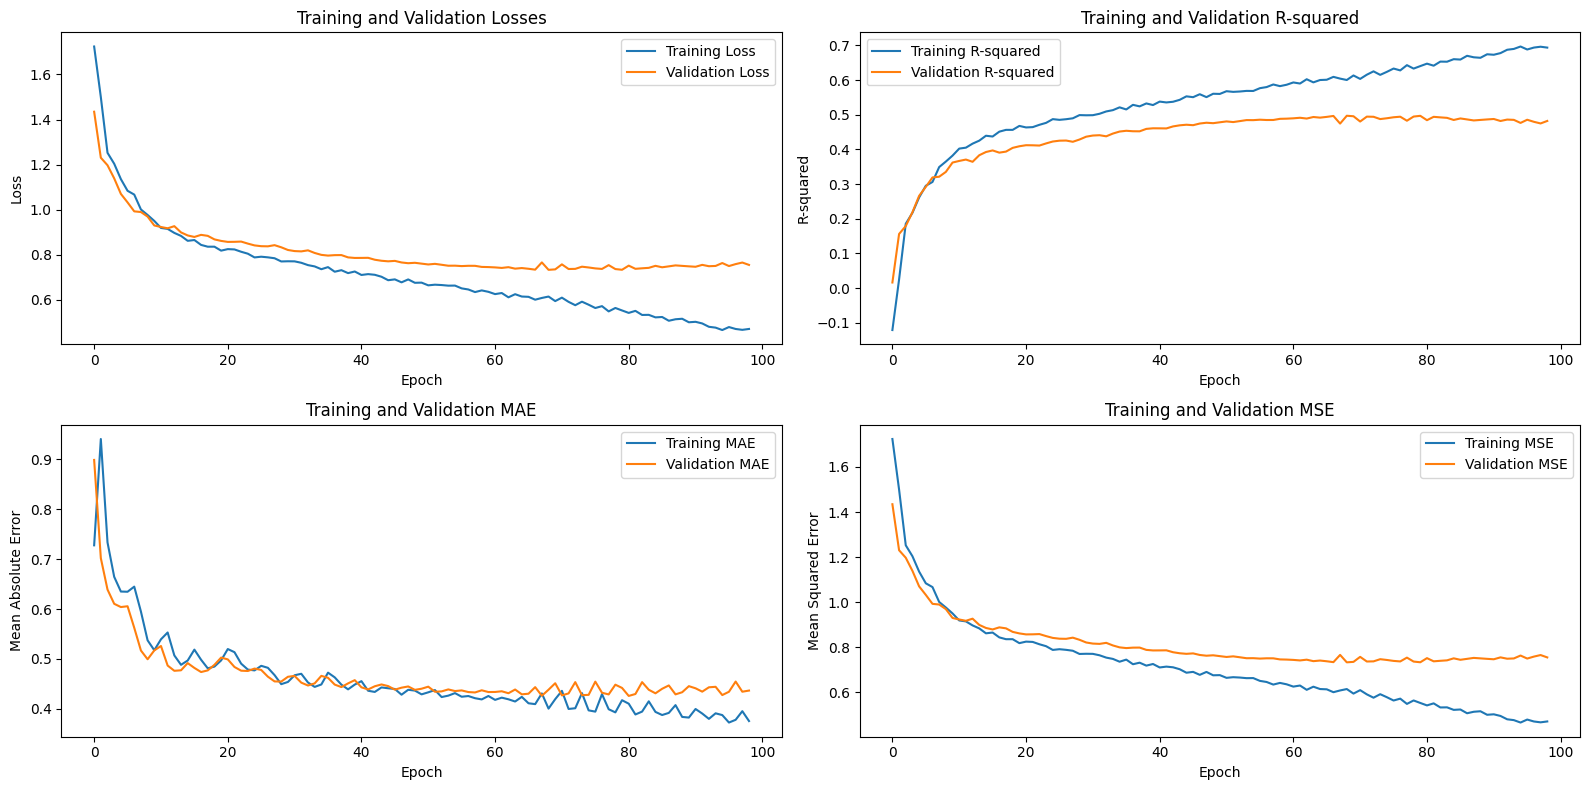

Test R-squared: 0.5131679067089392, Test MAE: 48.37114715576172, Test MSE: 9890.587890625, Avg Test Residual: 8.790285110473633


In [ ]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_LONDON.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_LONDON.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_LONDON.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')


extra reporting metrics


Test Loss: 0.7446293830871582, Test R-squared: 0.5131679067089392, Test MAE: 48.37114715576172, Test MSE: 9890.587890625


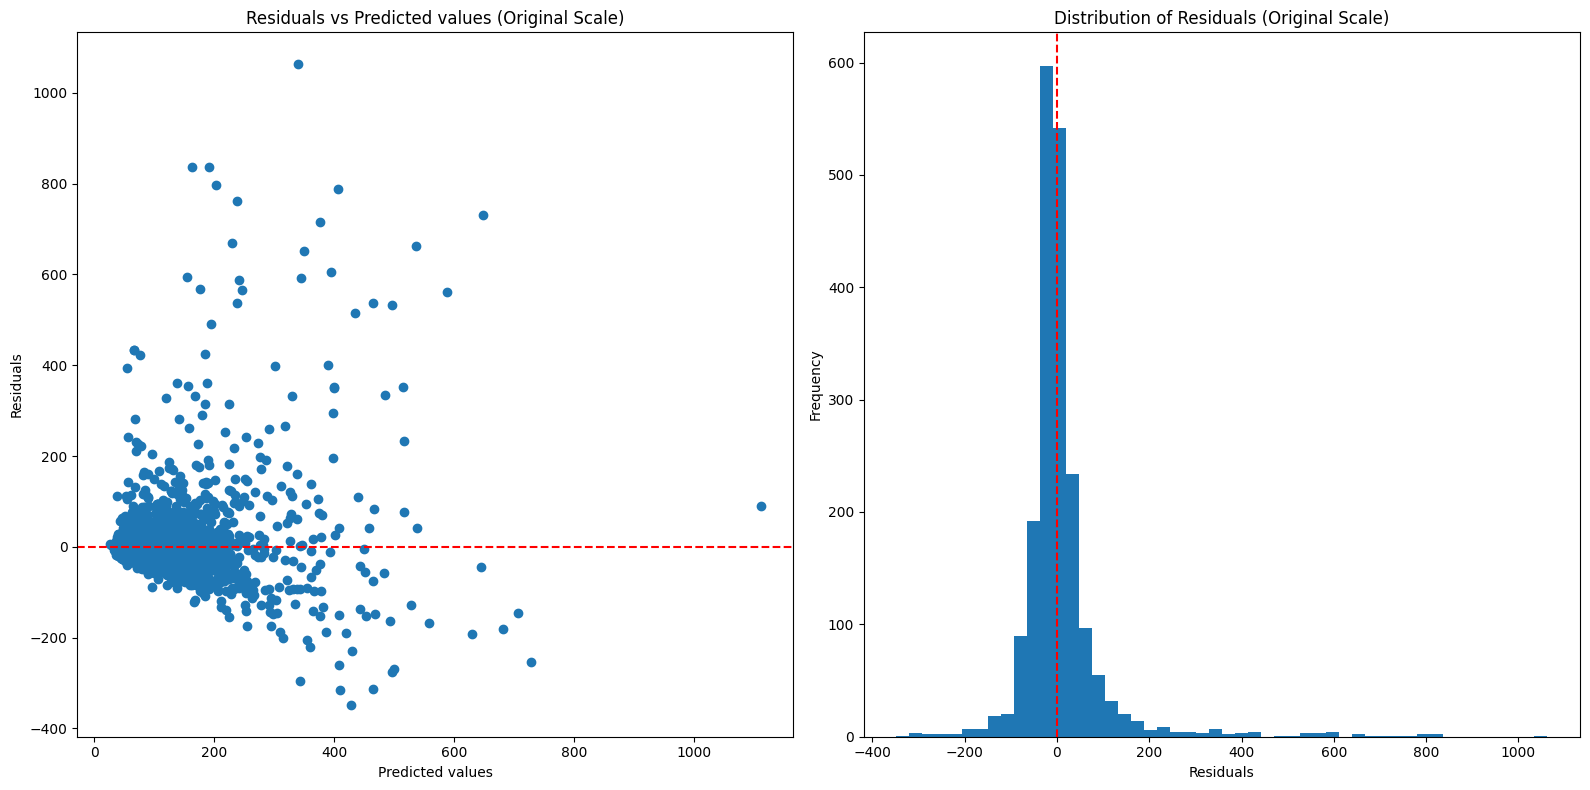

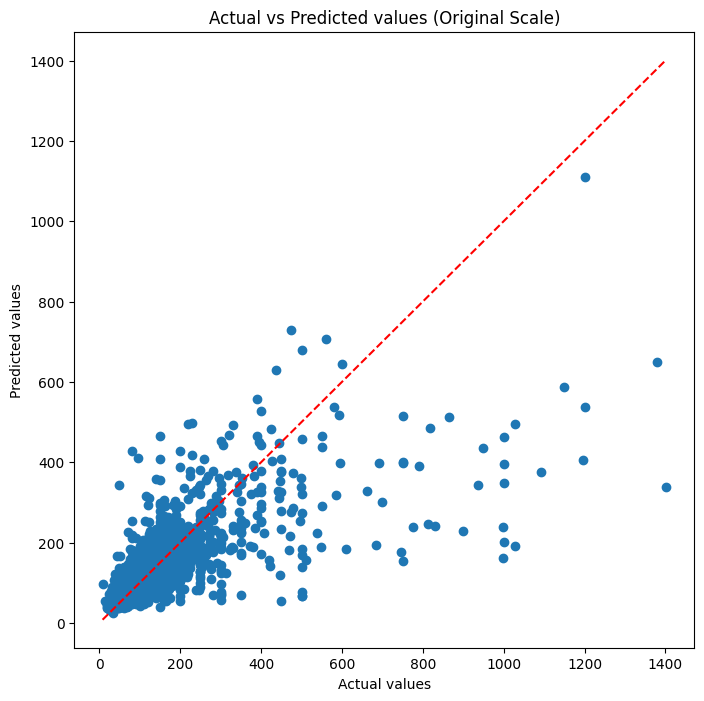

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

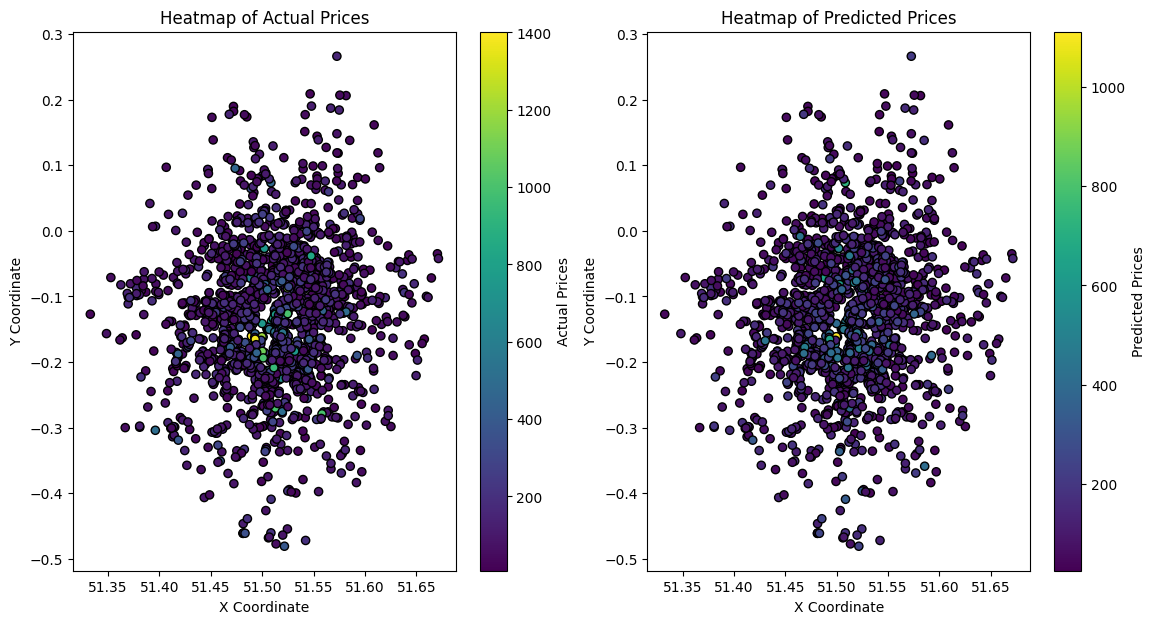

In [ ]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


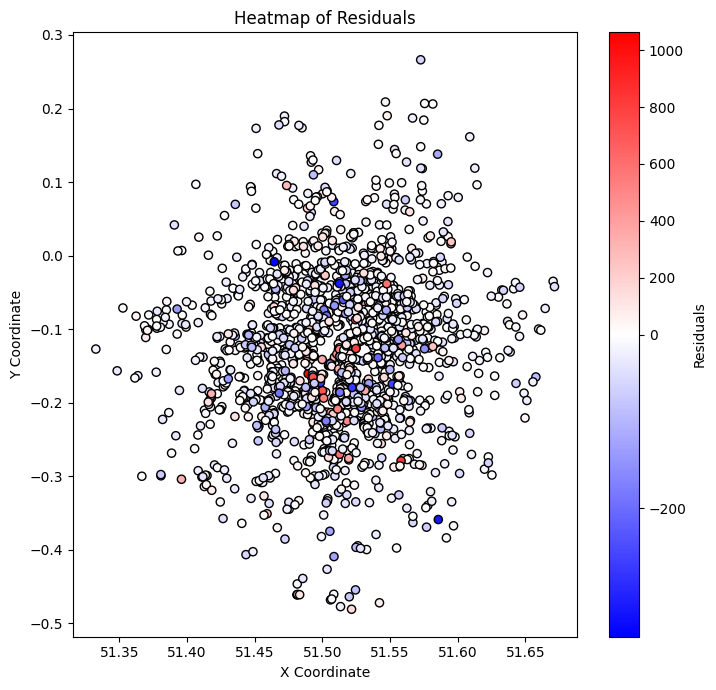

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


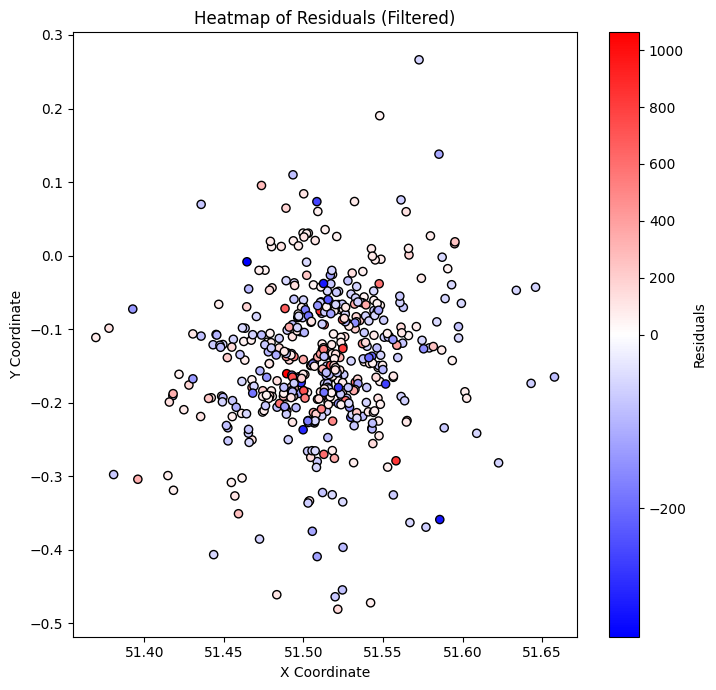

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


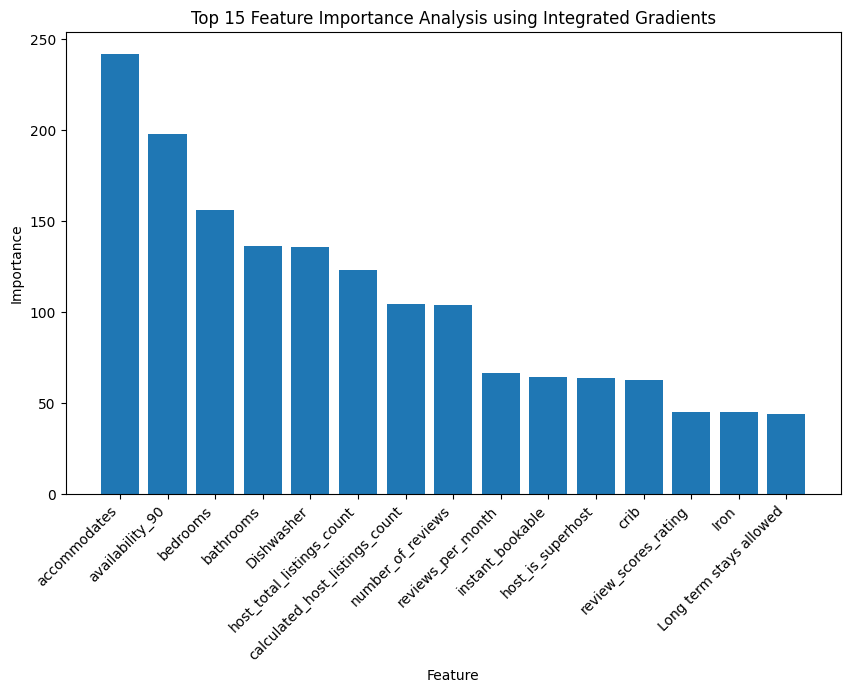

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


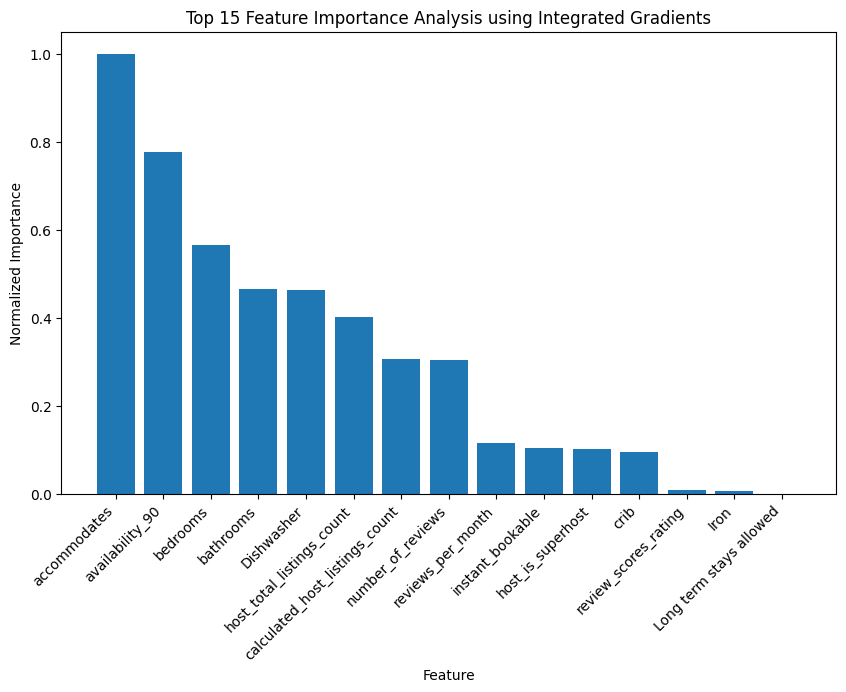

Top 15 Feature Importances (Normalized):
accommodates: 1.0000
availability_90: 0.7775
bedrooms: 0.5660
bathrooms: 0.4652
Dishwasher: 0.4635
host_total_listings_count: 0.4009
calculated_host_listings_count: 0.3062
number_of_reviews: 0.3035
reviews_per_month: 0.1157
instant_bookable: 0.1040
host_is_superhost: 0.1018
crib: 0.0954
review_scores_rating: 0.0076
Iron: 0.0052
Long term stays allowed: 0.0000


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")